# State politics affects COVID-19 spread

In [1]:
%matplotlib inline

In [2]:
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

In [3]:
votes = pd.read_csv(
    "./data-resources/StateAbbreviations.csv", index_col="Postalcode"
).join(
    pd.read_csv("./data-resources/state-electoral-2016.csv", index_col="State"), on="State"
)

In [4]:
votes["Affiliation"] = ["blue" if data.votesDem > data.votesRep else "red" for data in votes.itertuples()]

In [5]:
timeseries_tests = pd.DataFrame(requests.get("https://covidtracking.com/api/states/daily").json())
timeseries_tests['stateName'] = timeseries_tests.state
timeseries_tests.dateChecked = timeseries_tests.dateChecked.str.replace("T24", "T00")
timeseries_tests['dateColumn'] = pd.to_datetime(timeseries_tests.dateChecked)
timeseries_tests = timeseries_tests.sort_values('dateColumn')

In [6]:
timeseries_tests_sub = timeseries_tests[['date', 'state', 'positive', 'dateChecked', 'dateColumn', 'total', 'stateName']]

In [7]:
grouped_timeseries = timeseries_tests_sub.groupby(['state', 'dateChecked']).min()
grouped_timeseries['positive_ratio'] = timeseries_tests_sub.positive / timeseries_tests_sub.total

## Use `electoral_votes` ∩ `states_with_data`

We have to remove regions for which we don't have C19 data:

In [8]:
votes = votes.drop(["AS", "GU", "DC", "MH", "FM", "MP", "PW", "PR", "VI"])

In [9]:
# To list specific states:

# _states = {
#     'FL': votes.loc['FL'].Affiliation,
#     'NY': votes.loc['NY'].Affiliation,
#     'CA': votes.loc['CA'].Affiliation,
#     'MD': votes.loc['MD'].Affiliation,
#     'NJ': votes.loc['NJ'].Affiliation,
#     'GA': votes.loc['GA'].Affiliation,
#     'PA': votes.loc['PA'].Affiliation,
# }

# To list all states:
_states = {
    key: row.Affiliation
    for key, row in votes.iterrows()
}

## Utility functions

Here we define utility functions. These get kinda hairy, so I'd just avoid them if you're not looking to get your hands dirty.

In `get_dataset_doubling_period`, we use the fact that $T_d$ is approximatable using the slope of the line-of-best-fit of the log of the dataset $D$ at time $t$:

$$ln(d) = mt + t_0$$

In [10]:
millis_per_day = 60*60*24*1000*1000*1000
def get_dataset_doubling_period(dataset: pd.Series) -> Tuple[float, float]:
    """
    Calculate the doubling time of a dataset.
    
    We use the fact that $T_d$ is approximatable using the 
    slope of the line-of-best-fit of the log of the dataset 
    $D$ at time $t$:

    $$ln(d) = mt + d_0$$
    
    Arguments:
        dataset (pd.Series): A dataset with a datetime(str) index
    
    Returns:
        np.array: Where shape = (2,). First value is T_d, the
            second value is the time offset $d_0$ which we
            probably don't care about at all.
        
    """
    dataset = dataset[(dataset > 0) & (dataset < np.inf)]
    return np.polyfit(
        np.log(dataset),
        (
            pd.to_datetime(dataset.index, utc="True") - pd.to_datetime("Jan 1 2020", utc=True)
        ).astype(int) / millis_per_day, 1
    )

In [11]:
def plot_states(
    states: List[str] = None, 
    legend: Union[bool, List[str]] = False, 
    data_src = None, 
    plot_key: str = "positive"
):
    """
    Plot a timeseries chart of a value over time for several states.
    
    See [here](https://twitter.com/j6m8/status/1241533264520785921) for an example
    of outputs from this function.
    
    Arguments:
        states (List[str]): A list of states to plot. If none is provided, all states
            are plotted.
        legend (Union[bool, List[str]]): If True, all states from `states` are included
            in the legend. If `False`, no states are included in the legend. If you 
            pass a list, then only the states included in this list will be included in
            the legend. This is useful if you want to highlight a small set of states
            with all other states faded in the background.
        data_src (pd.DataFrame): The dataframe to use, if not `grouped_timeseries`. You
            should avoid changing this unless you know what you're doing.
        plot_key (str): The key to plot from the data_src variable. Defaults to `positive`
            but you can also use `death`, `tested`, etc. Be aware that not all states
            report non-positive values the same way.
        
    Returns:
        None, but leaves the plt context open
    """
    data_src = data_src if data_src else grouped_timeseries
    states = states if states else grouped_timeseries.stateName.unique()
    with plt.style.context("fivethirtyeight"):
        fig_scale = 2
        plt.figure(figsize=(8*fig_scale, 5*fig_scale))
        for state in states:
            in_legend = (
                legend is True or (isinstance(legend, list) and state in legend)
            )
            state_data = data_src.loc[state, :]
            state_data = state_data[state_data[plot_key] > 0]
            if in_legend:
                td = np.round(get_dataset_doubling_period(state_data.positive)[0], 2)
                plt.plot(
                    state_data.dateColumn, 
                    state_data[plot_key], 
                    label=f"{state} ($T_d$ = {td})",
                    c=_states[state] if state in _states else '#000000'
                )
            else:
                plt.plot(
                    state_data.dateColumn, 
                    state_data[plot_key], 
                    label=None,
                    color="#000000", alpha=0.02
                )
        if len(legend) < 10:
            plt.legend()
        plt.title("Total Confirmed Cases per State")
        plt.ylabel("Confirmed Cases")
        plt.xlabel("Date")

## Example Plots

Below are a few plots that show you how to use the plotting function above.

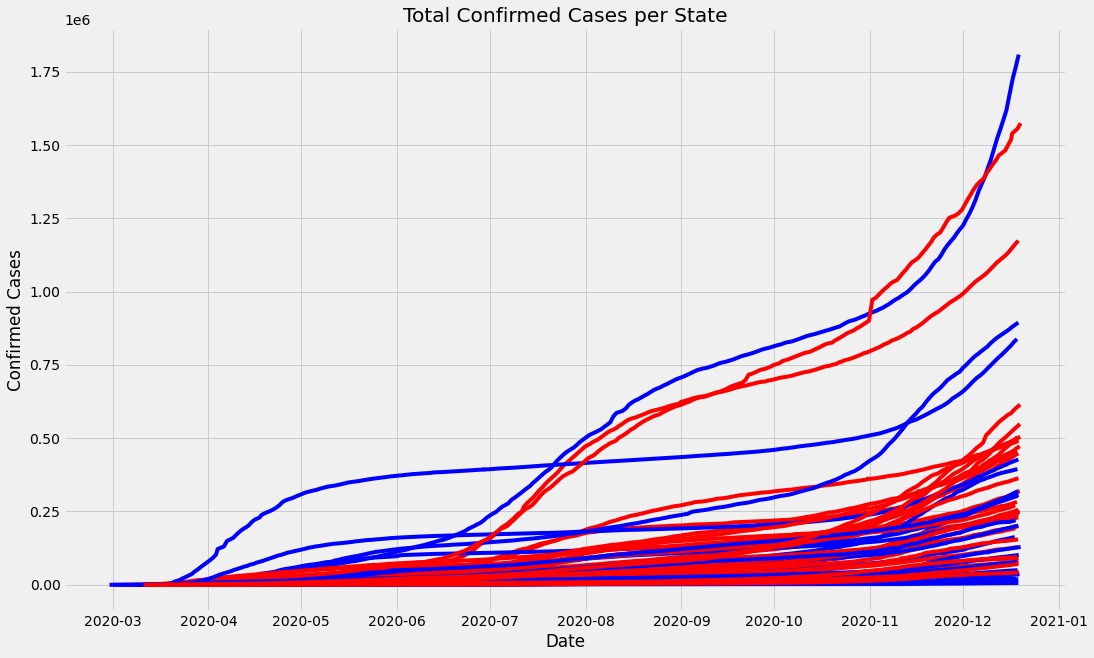

In [12]:
plot_states(legend=list(_states.keys()), plot_key="positive")

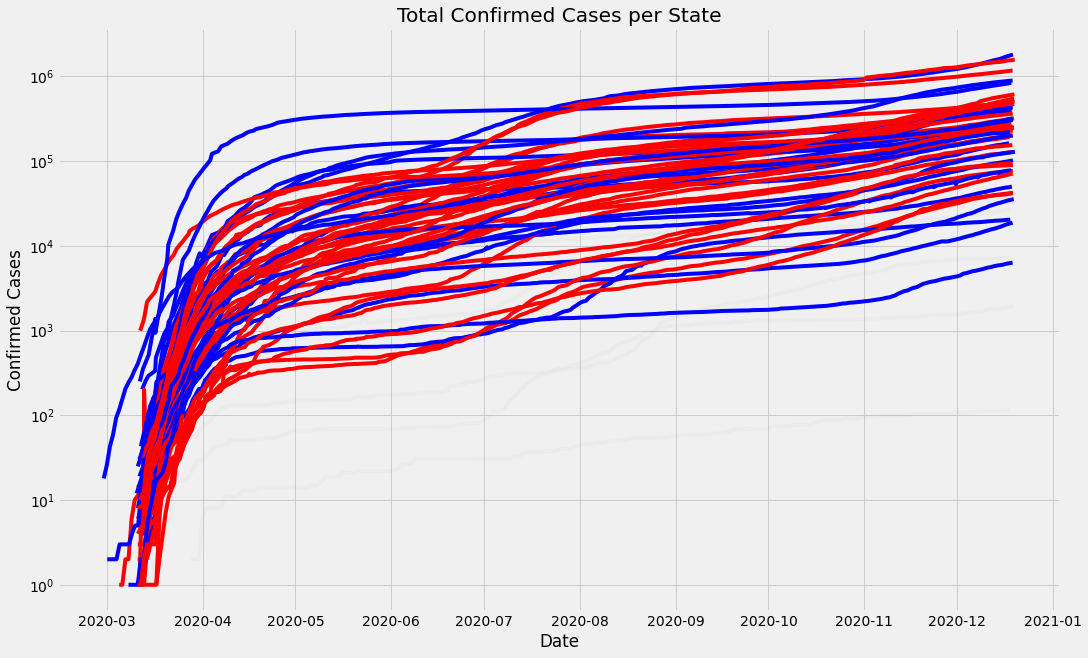

In [13]:
plot_states(legend=list(_states.keys()), plot_key="positive")
plt.yscale("log")
plt.show()

In [14]:
def plot_doubling_times(states: List[str]):
    with plt.style.context("fivethirtyeight"):
        fig_scale = 2
        plt.figure(figsize=(8*fig_scale, 5*fig_scale))
        for state in states:
            plt.plot(
                [
                    pd.to_datetime(grouped_timeseries.loc[state, :].index[d])
                    for d in range(6, len(grouped_timeseries.loc[state, :][:-3]))
                ], [
                    get_dataset_doubling_period(grouped_timeseries.loc[state, :][:d].positive)[0]
                    for d in range(6, len(grouped_timeseries.loc[state, :][:-3]))
                ],
                label=f"{state}",
                c=_states[state] if state in _states else '#000000'
            )
        plt.title("Doubling time of coronavirus per state over time (measured by reported positive tested cases)")
        plt.ylabel("$T_d$ for all data up until date...")
        plt.legend()

        
def plot_k_back_doubling_times(states: List[str], k: int = 14):
    with plt.style.context("fivethirtyeight"):
        fig_scale = 2
        plt.figure(figsize=(8*fig_scale, 5*fig_scale))
        for state in states:
            plt.plot(
                [
                    pd.to_datetime(grouped_timeseries.loc[state, :].index[d])
                    for d in range(k, len(grouped_timeseries.loc[state, :][:-3]))
                ], [
                    get_dataset_doubling_period(grouped_timeseries.loc[state, :][d-k:d].positive)[0]
                    for d in range(k, len(grouped_timeseries.loc[state, :][:-3]))
                ],
                label=f"{state}",
                c=_states[state] if state in _states else '#000000',
                alpha=0.3
            )
        plt.title(f"Doubling time of COVID-19 (using positive tests over previous {k} days)")
        plt.ylabel("$T_d$ for all data up until date...")

(0.0, 365.0)

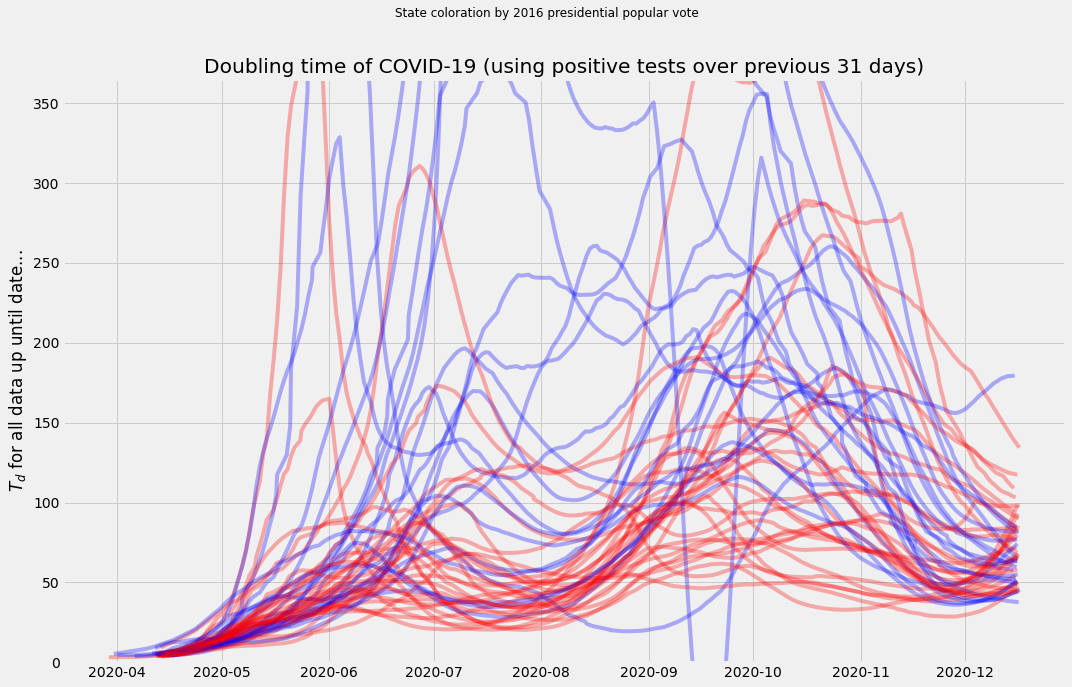

In [15]:
plot_k_back_doubling_times(list(_states.keys()), k=31)
# plot_k_back_doubling_times(['MA'], k=21)
# plt.legend()
plt.suptitle("State coloration by 2016 presidential popular vote")
plt.ylim(0, 365)